In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from extra_functions.functions import visualize, visualize_categorical, kde_by_category

In [2]:
flor_data_url = 'https://raw.githubusercontent.com/oconnoag/NHANES_Data/master/compiled_data/flor_compiled_raw.csv'
raw_data = pd.read_csv(flor_data_url)

## Column Renaming

In [3]:
processed_data_a = raw_data.copy()

In [4]:
processed_data_b = processed_data_a.rename(columns={'HSD010': 'general_health',
                                                    'RIDAGEYR': 'age',
                                                    'DMDHHSIZ': 'people_in_household',
                                                    'INDHHIN2': 'annual_income',
                                                    'DBQ700': 'healthy_diet',
                                                    'DBD900': 'number_meals_fastfood_past7',
                                                    'DBD910': 'number_frozen_past30',
                                                    'BMXBMI': 'bmi',
                                                    'PAQ635': 'walk_or_bike',
                                                    'PAQ650': 'vigorous_rec', 
                                                    'PAD680': 'sedentary',
                                                    })

## Cleaning Data

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8887 entries, 0 to 8886
Data columns (total 12 columns):
SEQN        8887 non-null float64
HSD010      6166 non-null float64
RIDAGEYR    8887 non-null float64
DMDHHSIZ    8887 non-null float64
INDHHIN2    8618 non-null float64
DBQ700      6063 non-null float64
DBD900      6757 non-null float64
DBD910      8821 non-null float64
BMXBMI      8756 non-null float64
PAQ635      6701 non-null float64
PAQ650      6699 non-null float64
PAD680      6687 non-null float64
dtypes: float64(12)
memory usage: 833.2 KB


In [6]:
processed_data = processed_data_b.copy()

In [7]:
# Drop any subject with empty values
processed_data = processed_data.dropna()

processed_data = processed_data[processed_data['annual_income'] < 77]
processed_data = processed_data[processed_data['healthy_diet'] != 9]
processed_data = processed_data[processed_data['vigorous_rec'] != 9]

In [8]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3997 entries, 0 to 8886
Data columns (total 12 columns):
SEQN                           3997 non-null float64
general_health                 3997 non-null float64
age                            3997 non-null float64
people_in_household            3997 non-null float64
annual_income                  3997 non-null float64
healthy_diet                   3997 non-null float64
number_meals_fastfood_past7    3997 non-null float64
number_frozen_past30           3997 non-null float64
bmi                            3997 non-null float64
walk_or_bike                   3997 non-null float64
vigorous_rec                   3997 non-null float64
sedentary                      3997 non-null float64
dtypes: float64(12)
memory usage: 405.9 KB


## Data Exploration

#### General Health Distribution

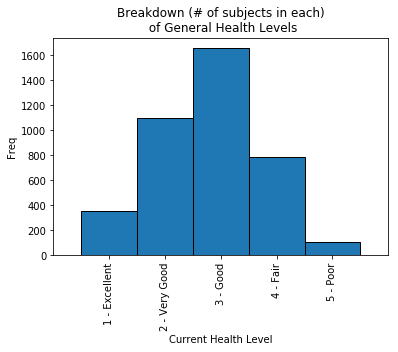

In [9]:
processed_data['general_health'].hist(grid=False, bins=np.arange(0,7,1)-0.5, ec='k')
plt.xlim([0,6])
plt.title('Breakdown (# of subjects in each)\n of General Health Levels')
plt.ylabel("Freq")
plt.xlabel("Current Health Level")
plt.xticks(np.arange(1,6), ['1 - Excellent', '2 - Very Good', '3 - Good', '4 - Fair', '5 - Poor'],
          rotation=90);

### Feature Selection/Culling

In [10]:
print("Mean by reported health level:")
display(processed_data.groupby('general_health').mean())
print('\n')
print("Standard Deviation by reported health level:")
processed_data.groupby('general_health').std()

Mean by reported health level:


,SEQN,age,people_in_household,annual_income,healthy_diet,number_meals_fastfood_past7,number_frozen_past30,bmi,walk_or_bike,vigorous_rec,sedentary
general_health,,,,,,,,,,,
1.0,88619.852273,41.369318,3.386364,10.051136,2.292614,1.792614,21.235795,25.396591,1.730114,1.482955,391.463068
2.0,88720.422587,41.817851,3.249545,10.153916,2.755009,1.925319,2.612022,27.414754,1.770492,1.563752,427.538251
3.0,88706.578757,44.839469,3.383826,9.080266,3.204587,5.482800,10.675920,29.801267,1.780326,1.737477,426.358479
4.0,88746.132653,48.002551,3.414541,7.382653,3.701531,2.357143,19.644133,32.320791,1.795918,1.840561,479.674745
5.0,88315.783019,51.084906,3.462264,6.452830,3.679245,2.537736,3.037736,33.630189,1.792453,1.896226,498.764151




Standard Deviation by reported health level:


,SEQN,age,people_in_household,annual_income,healthy_diet,number_meals_fastfood_past7,number_frozen_past30,bmi,walk_or_bike,vigorous_rec,sedentary
general_health,,,,,,,,,,,
1.0,2898.137970,20.053063,1.660205,4.346489,1.044400,2.601698,355.260818,4.712231,0.444532,0.500421,204.446801
2.0,2856.740124,19.380882,1.575110,4.254119,0.901279,2.361163,7.101602,6.000046,0.420708,0.496145,535.659766
3.0,2845.739635,18.892994,1.716622,4.259993,0.865902,136.439303,231.528471,6.841048,0.414151,0.440138,654.664472
4.0,2923.991632,18.407270,1.755951,3.955242,0.949664,2.832037,336.419016,8.350498,0.403286,0.366318,967.296187
5.0,2989.663185,18.127127,1.779109,3.680404,1.142655,3.324296,7.807109,9.459822,0.407477,0.306415,956.416621


#### Correlates with general_health
with a marked threshold of |0.05| correlation coefficient (Pearson's r) with general_health <br>

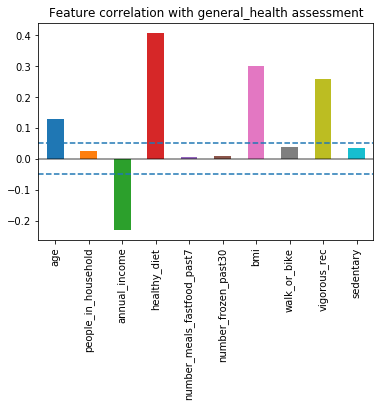

In [11]:
(processed_data.corr()['general_health'][2:]).plot.bar()
plt.axhline(y = 0.05, linestyle='--')
plt.axhline(y=0, linestyle='-', color='k', alpha=0.5)
plt.axhline(y = -0.05, linestyle='--')
plt.title("Feature correlation with general_health assessment");

In [12]:
corr_df = pd.DataFrame(processed_data.corr()['general_health'][2:]).abs().sort_values(by='general_health', 
                                                                           ascending=False)
display(corr_df)

,general_health
healthy_diet,0.408486
bmi,0.300060
vigorous_rec,0.257257
annual_income,0.231205
age,0.128481
walk_or_bike,0.036910
sedentary,0.034212
people_in_household,0.025747
number_frozen_past30,0.007942
number_meals_fastfood_past7,0.005505


## Analyze features that correlate with general_health
- Keeping only the features that make the |0.05| correlation-coefficient threshold for correlating with general_health (see the corr_df above)

In [13]:
correlating_features = list(corr_df[corr_df['general_health'] > 0.05].index)
print("Features to keep are:", correlating_features)
selected_features = processed_data[['general_health'] + correlating_features]
selected_features.head()

Features to keep are: ['healthy_diet', 'bmi', 'vigorous_rec', 'annual_income', 'age']


,general_health,healthy_diet,bmi,vigorous_rec,annual_income,age
0,3.0,3.0,27.8,2.0,10.0,62.0
2,4.0,4.0,28.8,2.0,5.0,78.0
3,3.0,4.0,42.4,2.0,10.0,56.0
4,4.0,5.0,20.3,2.0,7.0,42.0
5,3.0,3.0,28.6,2.0,14.0,72.0


## Visualizing Individual Columns with general_health

#### Healthy Diet

- Noticeable trend of having a healthy diet correlating with higher-perception of general health
- Less variance at the poor and excellent health values
- Medium general health values possibly multimodal
- Possible outliers present, especially at the medium values 2-4

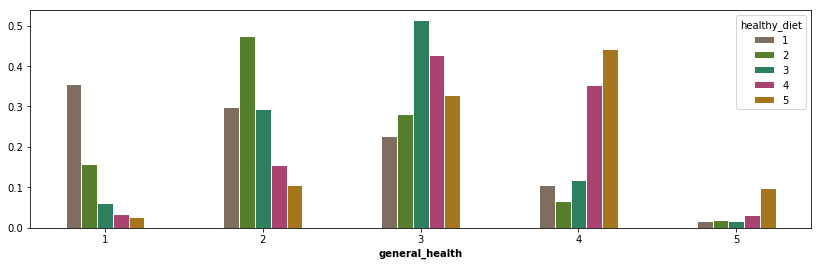

In [14]:
# set width of bar
barWidth = 0.10
 
# set height of bar
count_1 = list(selected_features[selected_features['healthy_diet'] == 1].groupby(by=['general_health'])['healthy_diet'].count())
bars1 = np.array(count_1) / sum(count_1)

count_2 = list(selected_features[selected_features['healthy_diet'] == 2].groupby(by=['general_health'])['healthy_diet'].count())
bars2 = np.array(count_2) / sum(count_2)

count_3 = list(selected_features[selected_features['healthy_diet'] == 3].groupby(by=['general_health'])['healthy_diet'].count())
bars3 = np.array(count_3) / sum(count_3)

count_4 = list(selected_features[selected_features['healthy_diet'] == 4].groupby(by=['general_health'])['healthy_diet'].count())
bars4 = np.array(count_4) / sum(count_4)

count_5 = list(selected_features[selected_features['healthy_diet'] == 5].groupby(by=['general_health'])['healthy_diet'].count())
bars5 = np.array(count_5) / sum(count_5)

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
 
# Make the plot
plt.figure(figsize=(14,4))
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='1')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='2')
plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='3')
plt.bar(r4, bars4, color='#AA4371', width=barWidth, edgecolor='white', label='4')
plt.bar(r5, bars5, color='#A6761D', width=barWidth, edgecolor='white', label='5')
 
# Add xticks on the middle of the group bars
plt.xlabel('general_health', fontweight='bold')
plt.xticks([r + barWidth*2 for r in range(len(bars1))], ['1', '2', '3', '4', '5']) 
    
# Create legend & Show graphic
plt.legend(title='healthy_diet')
plt.show()

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


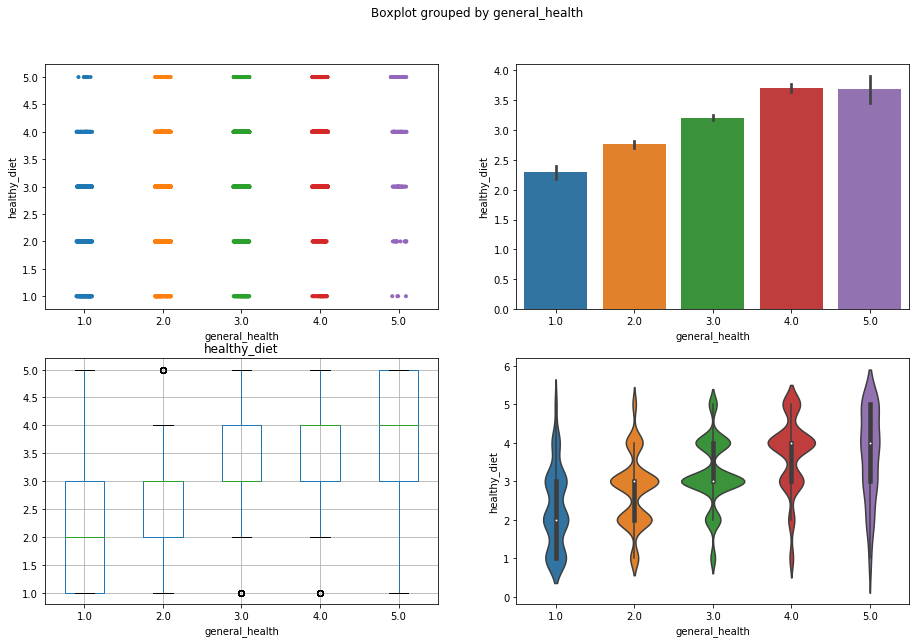

In [25]:
visualize(selected_features, 'general_health', 'healthy_diet')

#### Vigorous Exercise


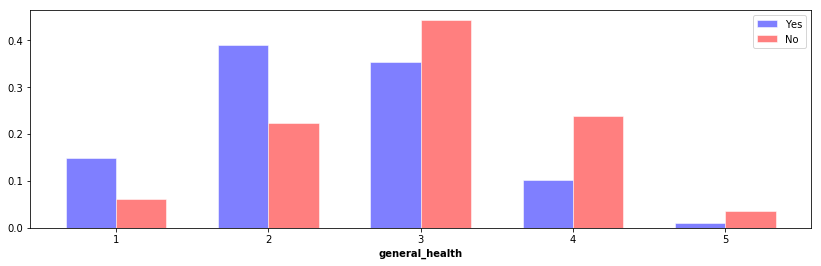

In [16]:
# set width of bar
barWidth = 0.33
 
# set height of bar
count_1 = list(selected_features[selected_features['vigorous_rec'] == 1].groupby(by=['general_health'])['vigorous_rec'].count())
bars1 = np.array(count_1) / sum(count_1)

count_2 = list(selected_features[selected_features['vigorous_rec'] == 2].groupby(by=['general_health'])['vigorous_rec'].count())
bars2 = np.array(count_2) / sum(count_2)


# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.figure(figsize=(14,4))
plt.bar(r1, bars1, color='blue', alpha=0.5, width=barWidth, edgecolor='white', label='Yes')
plt.bar(r2, bars2, color='red', alpha=0.5, width=barWidth, edgecolor='white', label='No')
 
# Add xticks on the middle of the group bars
plt.xlabel('general_health', fontweight='bold')
plt.xticks([r + barWidth * .5 for r in range(len(bars1))], ['1', '2', '3', '4', '5'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


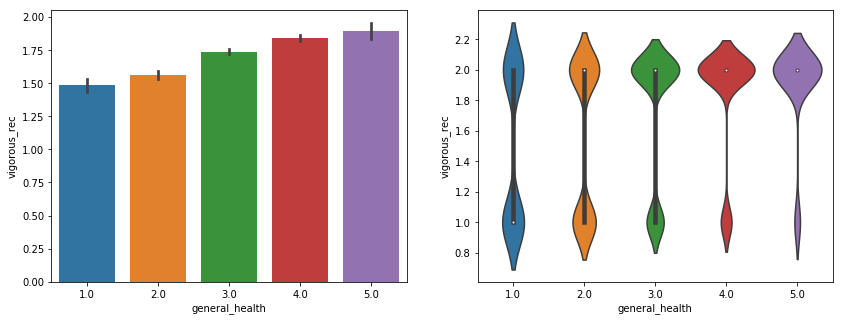

In [26]:
visualize_categorical(selected_features, 'general_health', 'vigorous_rec')

#### BMI
- Noticeable trend of BMI values between ~20-~35 correlating with higher-perception of general health
- Fair amount of variance in this data
- Significant number of outliers especially in 1-4 health perception levels

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


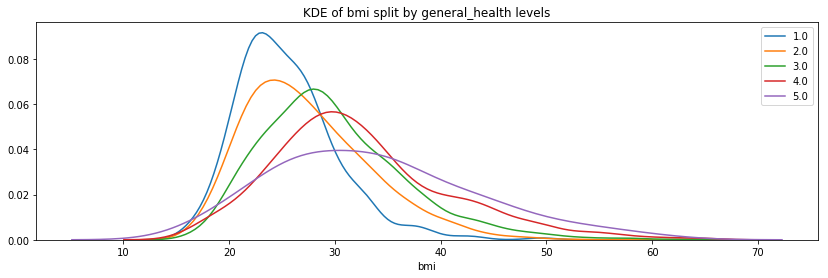

In [18]:
kde_by_category(selected_features, 'general_health', 'bmi')

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


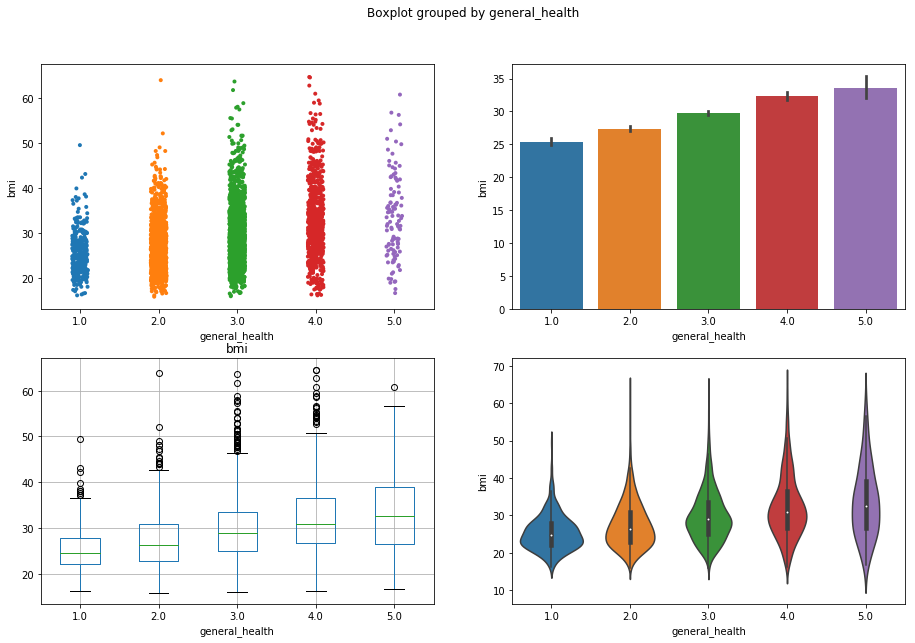

In [19]:
visualize(selected_features, 'general_health', 'bmi')

#### Annual Income
- General trend of lower income levels correlating with higher-perception of general health
- Distribution possibly bimodal
- Fair amount of variance for the poor health category

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


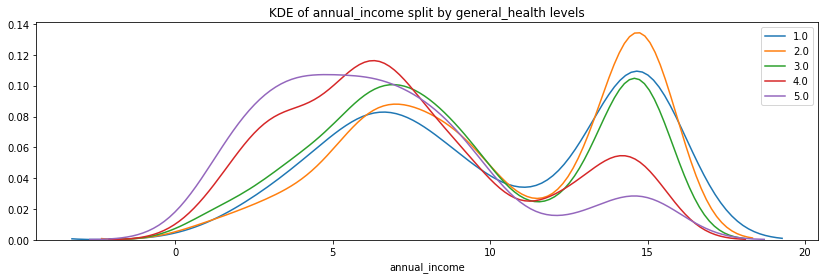

In [20]:
kde_by_category(selected_features, 'general_health', 'annual_income')

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


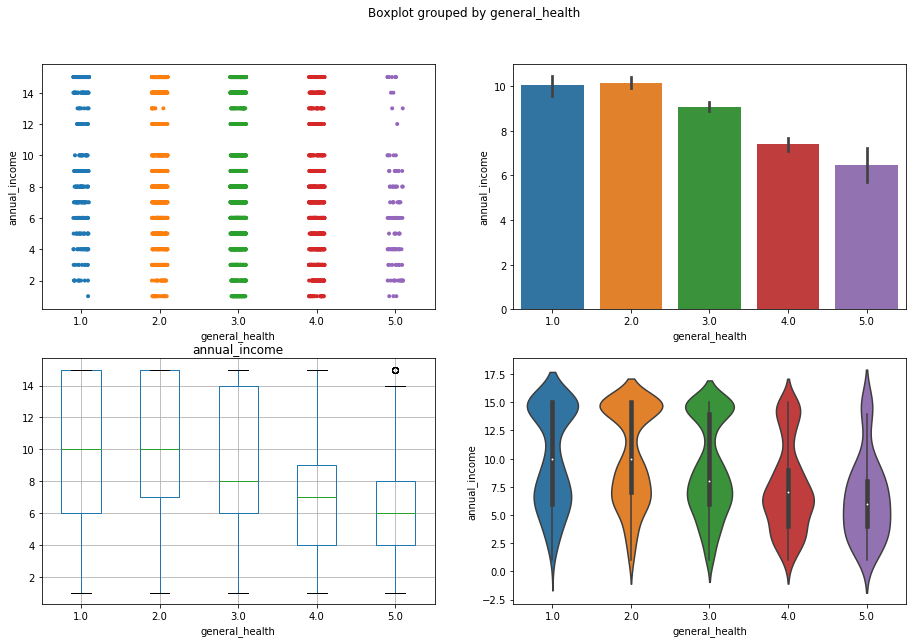

In [21]:
visualize(selected_features, 'general_health', 'annual_income')

#### Age
- Noticeable trend of higher age correlating with lower-perception of general health
- Evidence of decreasing number of poor health respondents for higher ages
- Roughly bimodal, with highest perceptions of general health (values 4 and 5) skewed to the right
- Possible outliers

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


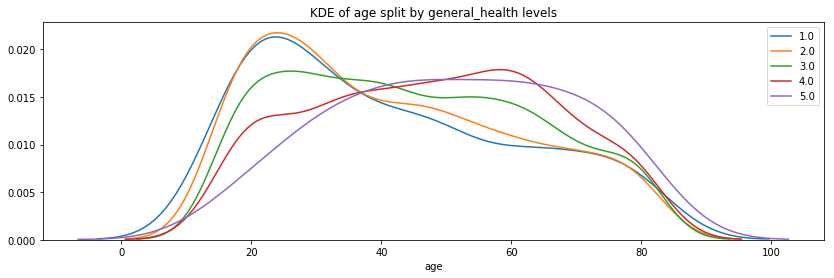

In [22]:
kde_by_category(selected_features, 'general_health', 'age')

## Any Colinearity?
** All Correlation Coefficients presented are Pearson's r ** <br>
The most concerning trends:
- Glucose and Glycohemoglobin are highly correlated (.79)
- Uric acid is correlated with a number of other features (including nearly |0.30| for blood_urea_nitrogen, SHBG, and testosterone
- Testosterone is correlated with iron at .29
- Triglycerides are correlated with Glucose and Glycohemoglib at ~0.2

#### Pairplot of variables meeting the 0.05 correlation threshold

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


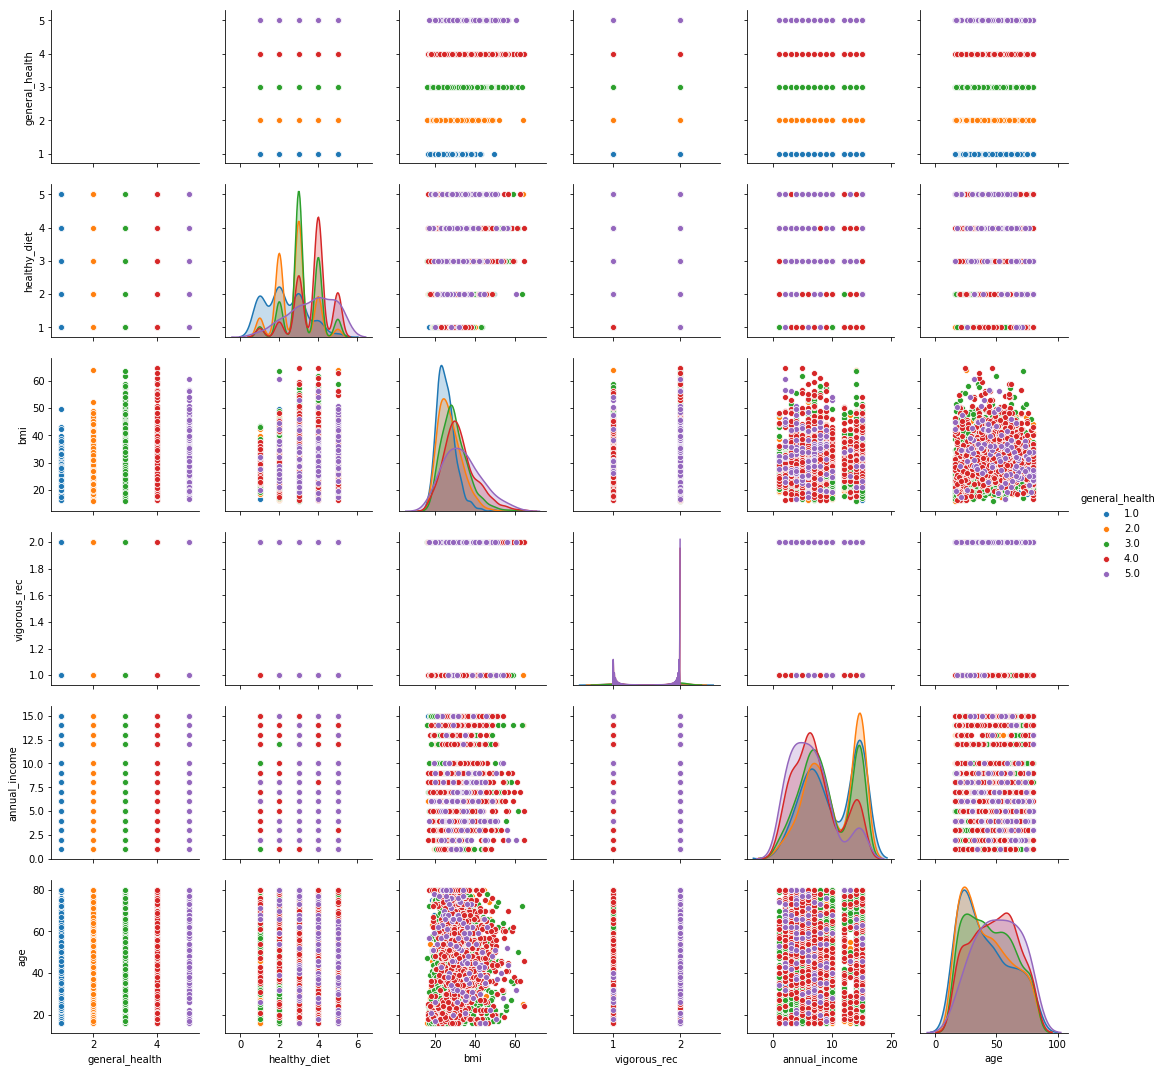

In [28]:
sns.pairplot(selected_features, hue='general_health', )

#### Heatmap

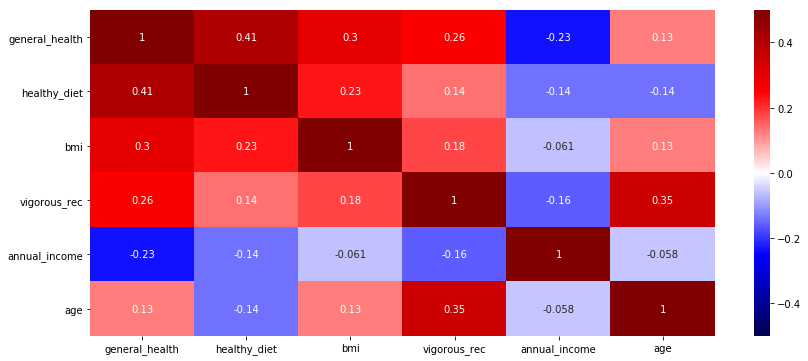

In [29]:
plt.figure(figsize=(14,6))
sns.heatmap(data=selected_features.corr(), vmin=-.5, vmax=.5, cmap='seismic', annot=True)